In [1]:
%matplotlib inline

In [2]:
import torch
import torch.optim as optim

import torch.nn as nn
import torch.nn.functional as F

from sklearn.metrics import accuracy_score

import numpy as np
import PIL
import random
from IPython.core.display import Image, display

import matplotlib.pyplot as plt

In [3]:
DEVICE_ID = 3
DEVICE = torch.device('cuda:%d' % DEVICE_ID)
torch.cuda.set_device(DEVICE_ID)

In [4]:
### Для запуска без GPU раскомментировать и закоментировать код выше
# DEVICE = torch.device('cpu')

In [5]:
np.random.seed(100500)

def data2image(data):
    res = np.transpose(np.reshape(data ,(3, 32,32)), (1,2,0))
    return PIL.Image.fromarray(np.uint8(res))

def imshow(img):
    if isinstance(img, torch.Tensor): img = img.numpy().astype('uint8')
    plt.imshow(np.transpose(img, (1, 2, 0)))
    
def prediction2classes(output_var):
    _, predicted = torch.max(output_var.data, 1)
    predicted.squeeze_()
    classes = predicted.tolist()
    return classes

def make_solution_pytorch(net, input_tensor, a_batch_size):
    res = []
    net = net.eval()
    cur_pos = 0
    while cur_pos <= len(input_tensor):
        outputs = net(input_tensor[cur_pos:cur_pos+a_batch_size])
        res += prediction2classes(outputs)
        cur_pos += a_batch_size
    return res

In [6]:
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms, utils
from PIL import Image

class CifarDataset(Dataset):
    def __init__(self, input_path, is_train=True, transform=None):
                        
        data = np.load(input_path)
        if is_train: 
            self.Y, self.X = np.hsplit(data, [1]) 
            self.Y = [item[0] for item in self.Y]
        else: 
            self.X = data
            self.Y = None
            
        self.X = self.X.reshape((self.X.shape[0], 3, 32, 32))
        self.X = self.X.transpose((0, 2, 3, 1)) #приводим к виду (N, H, W, C)
        self.X = [Image.fromarray(img) for img in self.X]
                
        self.transform = transform

    def __len__(self):
        return len(self.X)

    def __getitem__(self, idx):
        
        sample = self.X[idx]

        if self.transform: sample = self.transform(sample)

        if self.Y is None: return sample
        else: return (sample, self.Y[idx])

In [7]:
#Надо поменять пути на свои до файлов с kaggle
DATA_PATH  = '/home/a.murashev/2018_2/04/kaggle04_files/'
train_path = 'homework_4.train.npy'
test_path  = 'homework_4_no_classes.test.npy'

In [8]:
np_mean = np.mean([item[0].numpy() for item in CifarDataset(DATA_PATH + train_path, transform=transforms.ToTensor())], axis=(0,2,3))
np_std = np.std([item[0].numpy() for item in CifarDataset(DATA_PATH + train_path, transform=transforms.ToTensor())], axis=(0,2,3))

In [9]:
np_mean.shape

(3,)

In [10]:
cifar_transform_norm = transforms.Compose([
    transforms.Pad(4),
    transforms.RandomCrop(32),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize(torch.FloatTensor(np_mean), torch.FloatTensor(np_std))
]
)

cifar_test_transform_norm = transforms.Compose([    
    transforms.ToTensor(),
    transforms.Normalize(torch.FloatTensor(np_mean), torch.FloatTensor(np_std))
]
)

In [35]:
dataset_train_norm = CifarDataset(DATA_PATH + train_path, transform=cifar_transform_norm)
dataloader_train_norm = DataLoader(dataset_train_norm, batch_size=128,
                        shuffle=True, num_workers=4)

dataset_test_norm = CifarDataset(DATA_PATH + test_path, is_train=False, transform=cifar_test_transform_norm)
dataloader_test_norm = DataLoader(dataset_test_norm, batch_size=128,
                        shuffle=False, num_workers=1)


def train_network(a_net, 
                  a_device,
                  dataloader_train_norm=dataloader_train_norm,
                  a_epochs=164,
                  a_batch_size=128,
                  a_lr=0.1):
    
    train_acc = []
    net = a_net.to(a_device)

    criterion = nn.CrossEntropyLoss()
    optimizer = torch.optim.SGD(a_net.parameters(), lr=a_lr, weight_decay=0.0001, momentum=0.9)

    
    for epoch in range(a_epochs):  # loop over the dataset multiple times
        if epoch == 82:
            optimizer = torch.optim.SGD(a_net.parameters(), lr=a_lr/10, weight_decay=0.0001, momentum=0.9) 
        elif epoch == 123:
            optimizer = torch.optim.SGD(a_net.parameters(), lr=a_lr/100, weight_decay=0.0001, momentum=0.9) 
        
        net = net.train()        
        epoch_accuracy = 0.0
        epoch_iters = 0
        for item in dataloader_train_norm:
            
            epoch_iters += 1

            inputs = item[0].to(a_device)
            labels = item[1].long().to(a_device)

            # zero the parameter gradients
            optimizer.zero_grad()

            # forward + backward + optimize
            outputs = net(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            epoch_accuracy += accuracy_score(labels, prediction2classes(outputs))

        epoch_accuracy /= epoch_iters
        train_acc.append(epoch_accuracy)
        
        print("Epoch ", epoch, round(train_acc[-1], 4))

    print('Finished Training')
    
    plt.plot(train_acc, label='Train')
    plt.legend()
    plt.grid()

In [12]:
class StupidDenseNet(nn.Module):
    
    def __init__(self):
        super(StupidDenseNet, self).__init__()
        
        #Один из способов задать сеть - это задать последовательность слоев через Sequential
        self.classifier = nn.Sequential()
        self.classifier.add_module('lin1', nn.Linear(3*32*32, 500))
        self.classifier.add_module('sig1', torch.nn.Sigmoid())
        self.classifier.add_module('lin2', nn.Linear(500, 300))
        self.classifier.add_module('sig2', torch.nn.Sigmoid())
        self.classifier.add_module('lin3', nn.Linear(300, 100))
        self.classifier.add_module('sig3', torch.nn.Sigmoid())
        
    def forward(self, x):
        x = x.view((x.size()[0], -1))
        x = self.classifier(x)
        return x

In [13]:
class LeNet(nn.Module):

    def __init__(self):
        super(LeNet, self).__init__()

        ### Другой способ задания сети - это описать слои и в forward их применять явно
        
        self.conv1 = nn.Conv2d(3, 6, 5)
        self.conv2 = nn.Conv2d(6, 16, 5)
        # an affine operation: y = Wx + b
        self.fc1 = nn.Linear(16 * 5 * 5, 120)
        #Увеличиваем кол-во выходных слоев с 84 - до 84*2 - потому что классов 100
        self.fc2 = nn.Linear(120, 84*2)
        self.fc3 = nn.Linear(84*2, 100)

    def forward(self, x):
        # Max pooling over a (2, 2) window
        x = F.max_pool2d(F.relu(self.conv1(x)), (2, 2))
        # If the size is a square you can only specify a single number
        x = F.max_pool2d(F.relu(self.conv2(x)), 2)
        x = x.view(-1, self.num_flat_features(x))
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x

    def num_flat_features(self, x):
        size = x.size()[1:]  # all dimensions except the batch dimension
        num_features = 1
        for s in size:
            num_features *= s
        return num_features

In [44]:
class CifarResidualBlock(nn.Module):
    def __init__(self, a_in_channels, make_downsample=False, use_skip_connection=True):
        super(CifarResidualBlock, self).__init__()
        self.use_skip_connection = use_skip_connection
        
        if make_downsample: coef = DOWNSAMPLE_COEF
        else: coef = 1  
            
        ### TODO - нужно описать используемые блоки
        pass
            
    def forward(self, x):
        ###TODO - описать forward блок с учетом флагов make_downsample и use_skip_connection
        return x

In [15]:
class CifarResNet(nn.Module):
    
    def __init__(self):
        super(CifarResNet, self).__init__()
        
        #TODO нужно добавить блоков resnet и других слоев при необходимости
        
        self.features = nn.Sequential()
        
        #...
        self.features.add_module('res_block1', CifarResidualBlock(16))
        #...
        
        self.global_avg_pooling = nn.AvgPool2d(kernel_size=?)
        self.fc_classifier = nn.Linear(?, 100)
        
    def forward(self, x):
        x = self.features(x)
        x = self.global_avg_pooling(x)        
        x = x.view((x.size()[0], -1))        
        x = self.fc_classifier(x)        
        return x

Epoch  0 0.0211
Epoch  1 0.0425
Epoch  2 0.0474
Epoch  3 0.0504
Epoch  4 0.0549
Epoch  5 0.0547
Epoch  6 0.0558
Epoch  7 0.0575
Epoch  8 0.0615
Epoch  9 0.0608
Epoch  10 0.0641
Epoch  11 0.0648
Epoch  12 0.0702
Epoch  13 0.0709
Epoch  14 0.076
Epoch  15 0.0771
Epoch  16 0.0781
Epoch  17 0.0814
Epoch  18 0.0819
Epoch  19 0.0821
Epoch  20 0.0855
Epoch  21 0.0875
Epoch  22 0.0891
Epoch  23 0.0878
Epoch  24 0.0913
Epoch  25 0.093
Epoch  26 0.0937
Epoch  27 0.0941
Epoch  28 0.0935
Epoch  29 0.0976
Epoch  30 0.0985
Epoch  31 0.0995
Epoch  32 0.1006
Epoch  33 0.1014
Epoch  34 0.1038
Epoch  35 0.1039
Epoch  36 0.1053
Epoch  37 0.1071
Epoch  38 0.1068
Epoch  39 0.109
Epoch  40 0.1083
Epoch  41 0.11
Epoch  42 0.1111
Epoch  43 0.1115
Epoch  44 0.1131
Epoch  45 0.1135
Epoch  46 0.1159
Epoch  47 0.1155
Epoch  48 0.1158
Epoch  49 0.1187
Epoch  50 0.1184
Epoch  51 0.1198
Epoch  52 0.1193
Epoch  53 0.1205
Epoch  54 0.1227
Epoch  55 0.1218
Epoch  56 0.1208
Epoch  57 0.1223
Epoch  58 0.1243
Epoch  59 0.

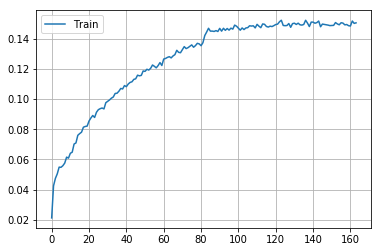

In [16]:
dense_net = StupidDenseNet()
%time train_network(dense_net, torch.device(DEVICE))

Epoch  0 0.0537
Epoch  1 0.0813
Epoch  2 0.0945
Epoch  3 0.103
Epoch  4 0.1088
Epoch  5 0.1098
Epoch  6 0.113
Epoch  7 0.111
Epoch  8 0.1175
Epoch  9 0.1137
Finished Training
CPU times: user 29min 3s, sys: 40min 43s, total: 1h 9min 46s
Wall time: 3min 16s


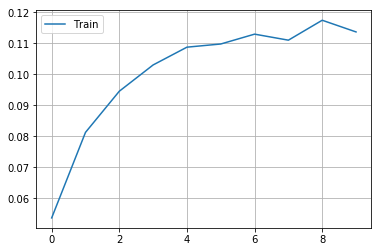

In [41]:
lenet = LeNet()
%time train_network(lenet, torch.device('cpu'), a_epochs=10)

Epoch  0 0.0487
Epoch  1 0.0793
Epoch  2 0.098
Epoch  3 0.1066
Epoch  4 0.1119
Epoch  5 0.1176
Epoch  6 0.1195
Epoch  7 0.1218
Epoch  8 0.1222
Epoch  9 0.1233
Finished Training
CPU times: user 19.3 s, sys: 7.65 s, total: 27 s
Wall time: 39.3 s


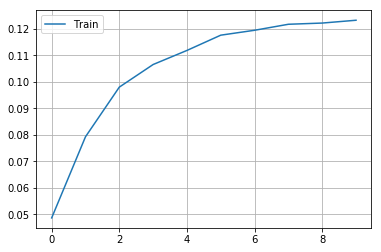

In [42]:
lenet = LeNet()
%time train_network(lenet, torch.device(DEVICE), a_epochs=10)

Epoch  0 0.0529
Epoch  1 0.0822
Epoch  2 0.0944
Epoch  3 0.1052
Epoch  4 0.1096
Epoch  5 0.1139
Epoch  6 0.1147
Epoch  7 0.117
Epoch  8 0.1198
Epoch  9 0.1242
Epoch  10 0.1226
Epoch  11 0.1251
Epoch  12 0.1215
Epoch  13 0.1293
Epoch  14 0.127
Epoch  15 0.1239
Epoch  16 0.1312
Epoch  17 0.1274
Epoch  18 0.1295
Epoch  19 0.1299
Epoch  20 0.1287
Epoch  21 0.1286
Epoch  22 0.1286
Epoch  23 0.1339
Epoch  24 0.1319
Epoch  25 0.1329
Epoch  26 0.1337
Epoch  27 0.1298
Epoch  28 0.1323
Epoch  29 0.1316
Epoch  30 0.1366
Epoch  31 0.1335
Epoch  32 0.1369
Epoch  33 0.136
Epoch  34 0.1364
Epoch  35 0.1338
Epoch  36 0.1408
Epoch  37 0.1336
Epoch  38 0.1348
Epoch  39 0.1411
Epoch  40 0.1421
Epoch  41 0.1381
Epoch  42 0.1346
Epoch  43 0.1347
Epoch  44 0.1397
Epoch  45 0.1392
Epoch  46 0.1355
Epoch  47 0.1373
Epoch  48 0.138
Epoch  49 0.1357
Epoch  50 0.1384
Epoch  51 0.1376
Epoch  52 0.1363
Epoch  53 0.1343
Epoch  54 0.1391
Epoch  55 0.1384
Epoch  56 0.136
Epoch  57 0.1358
Epoch  58 0.1367
Epoch  59 0.

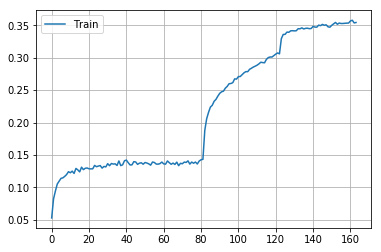

In [43]:
lenet = LeNet()
%time train_network(lenet, torch.device(DEVICE))

In [ ]:
resnet = CifarResNet()
%time train_network(resnet, torch.device(DEVICE))

# Важно переключить сеть в режим eval - иначе dropout будет работать некорректно

In [45]:
def make_solution(a_net, a_device):
    res = []
    net = a_net.eval()
    for item in dataloader_test_norm:
        inputs = item.to(a_device)
        outputs = net(inputs) 

        res += prediction2classes(outputs)
    return res

In [46]:
# my_solution = make_solution(dense_net, DEVICE)
my_solution = make_solution(lenet, DEVICE)

In [47]:
with open('my_solution.csv', 'w') as fout:
    print('Id', 'Prediction', sep=',', file=fout)
    for i, prediction in enumerate(my_solution):
        print(i, prediction, sep=',', file=fout)